In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import collections
from IPython import display
import import_ipynb
from util import utils

# 环境

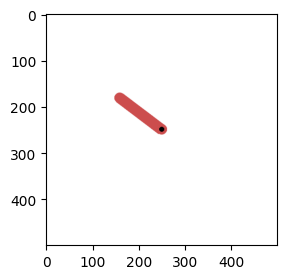

In [2]:
env = utils.PendulumEnv()
env.reset()
env.show()

# 算法定义

## 策略网络

In [3]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob

## 价值网络

In [4]:
class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

## SAC类（连续动作环境）

In [5]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    name = 'SAC'
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

    def play(self, env, update=False, show=False, replay_buffer=None):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                # 当 buffer数据的数量超过一定值后，才更新网络
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
        return episode_return   

# 初始化

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [7]:
buffer_size = 10000
batch_size = 64
minimal_size = 500
replay_buffer = utils.ReplayBuffer(buffer_size)

In [8]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
target_entropy = -env.action_space.shape[0]
tau = 0.005  # 软更新参数
gamma = 0.99
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

In [9]:
num_episodes = 100
epochs = 10

# 玩一局游戏（训练前）

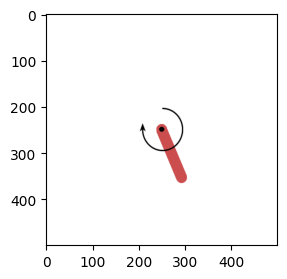

回报：85.24939741341703


In [10]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [11]:
def train(env, agent, num_episodes, epochs, replay_buffer=None):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show, replay_buffer)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [12]:
return_list = train(env=env, agent=agent, num_episodes=num_episodes, epochs=epochs, replay_buffer=replay_buffer)

Iteration 9: 100%|████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it, episode=100, return=175.717]


## 训练结果

### 训练回报

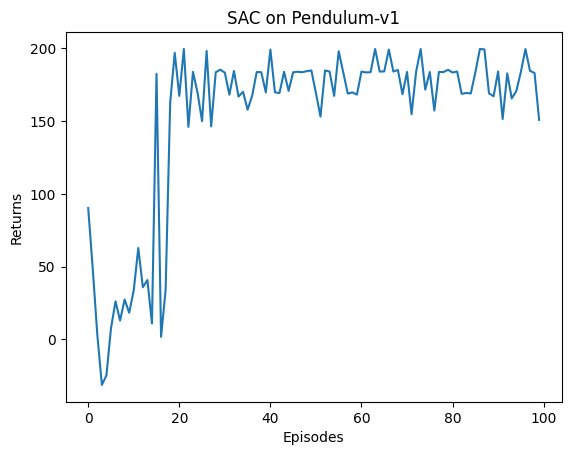

In [13]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

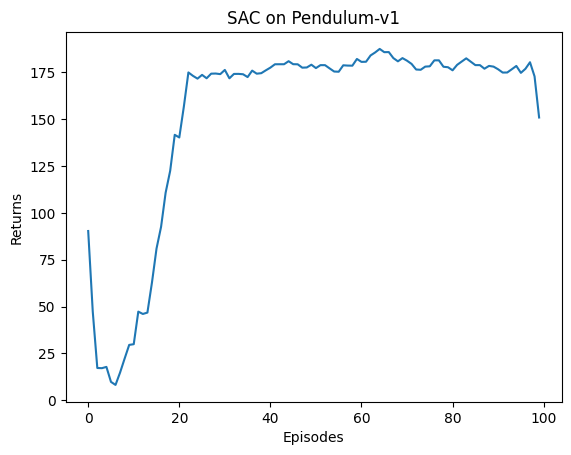

In [14]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(mv_return, agent, env)

# 再玩一局游戏（训练后）

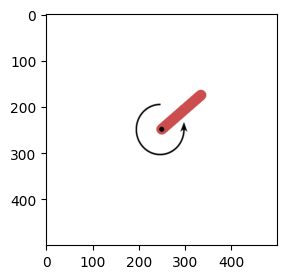

回报：152.28973146584008


In [15]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))